Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 58.7MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.12MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Epoch [1/10], Train Loss: 0.591, Train Accuracy: 84.46%, Val Loss: 0.194, Val Accuracy: 94.45%
Epoch [2/10], Train Loss: 0.144, Train Accuracy: 95.80%, Val Loss: 0.102, Val Accuracy: 96.74%
Epoch [3/10], Train Loss: 0.091, Train Accuracy: 97.28%, Val Loss: 0.071, Val Accuracy: 97.59%
Epoch [4/10], Train Loss: 0.070, Train Accuracy: 97.90%, Val Loss: 0.058, Val Accuracy: 98.09%
Epoch [5/10], Train Loss: 0.061, Train Accuracy: 98.18%, Val Loss: 0.051, Val Accuracy: 98.30%
Epoch [6/10], Train Loss: 0.054, Train Accuracy: 98.36%, Val Loss: 0.050, Val Accuracy: 98.32%
Epoch [7/10], Train Loss: 0.049, Train Accuracy: 98.53%, Val Loss: 0.050, Val Accuracy: 98.41%
Epoch [8/10], Train Loss: 0.045, Train Accuracy: 98.64%, Val Loss: 0.046, Val Accuracy: 98.45%
Epoch [9/10], Train Loss: 0.043, Train Accuracy: 98.70%, Val Loss: 0.046, Val Accuracy: 98.41%
Epoch [10/10], Train Loss: 0.041, Train Accuracy: 98.77%, Val Loss: 0.046, Val Accuracy: 98.43%


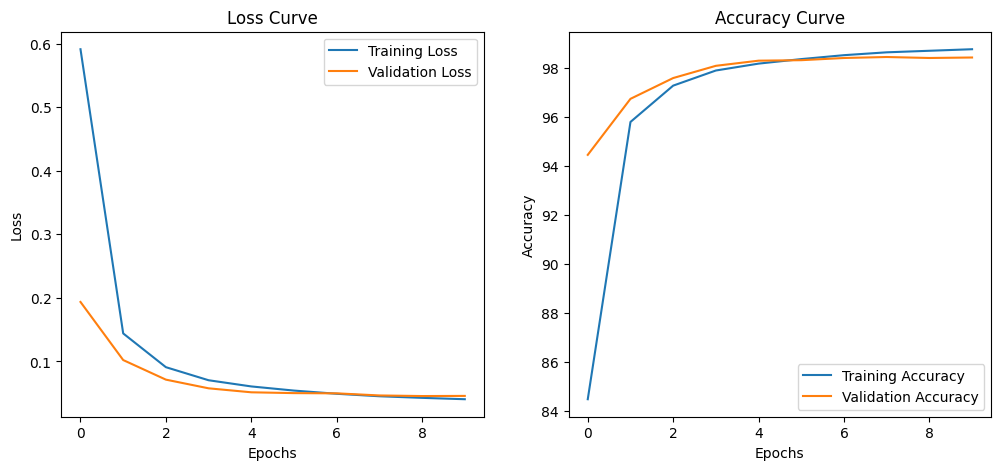

F1 score: 0.9843
Confusion Matrix:
[[ 978    0    0    0    0    0    0    1    1    0]
 [   0 1128    1    2    1    1    1    1    0    0]
 [   6    3 1003    6    3    0    0    5    5    1]
 [   1    0    0 1005    0    2    0    1    1    0]
 [   2    0    0    0  967    0    1    1    2    9]
 [   1    0    1    5    0  881    1    1    0    2]
 [  15    2    0    0    4   11  925    0    1    0]
 [   0    1    6    5    0    0    0 1012    1    3]
 [   8    0    1    2    1    2    0    2  950    8]
 [   2    1    0    1    1    4    0    4    2  994]]


In [1]:
import torch
from torch import nn, optim
from torch.utils import data
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Output: (16, 28, 28)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)  # Output: (16, 13, 13)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Output: (32, 13, 13)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (32, 6, 6)
        self.fc1 = nn.Linear(32 * 6 * 6, 10)  # Adjusted input size

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 32 * 6 * 6)
        x = self.fc1(x)
        return x

# Set device
device = 'cpu'
cnn = CNN().to(device)

# Hyperparameters
epochs = 10
batch_size = 300

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Load MNIST dataset
mnist_train = MNIST(root='mnist', train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root='mnist', train=False, download=False, transform=ToTensor())

# DataLoader for training and testing
train_loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    cnn.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = cnn(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = epoch_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    cnn.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = cnn(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}%')

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation
cnn.eval()
labels_true = []
labels_pred = []

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    outputs = cnn(imgs)
    _, predicted = torch.max(outputs.data, 1)
    
    labels_true += labels.tolist()
    labels_pred += predicted.tolist()

# Calculate F1 score and confusion matrix
f1 = f1_score(labels_true, labels_pred, average='micro')
confusion_mat = confusion_matrix(labels_true, labels_pred)

print(f'F1 score: {f1:.4f}')
print('Confusion Matrix:')
print(confusion_mat)